In [1]:
from pprint import pprint
import datetime
import os

In [27]:
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append("../")
# If this notebook file is not placed under in /notebook/ directory,
# adding directory "../" might not correly add the project directory.
# If adding "../" does not solve the importing problem, we need to setup 
# the directory mannually.
try:
    import constants
except ModuleNotFoundError:
    core_dir = input("Directory of core files >>> ")
    if not core_dir.endswith("/"):
        core_dir += "/"
    sys.path.append(core_dir)
    import constants

In [10]:
import core.genetic.control as control
import core.genetic.tuner as tuner
import core.tools.rnn_prepare as rnn_prepare
import core.models.stacked_lstm as stacked_lstm

In [11]:
# Load dataset.
print("Dataset paths saved:")
pprint(constants.DATA_DIR)
choice = None
while choice is None or choice not in constants.DATA_DIR.keys():
    if choice is not None:
        print("Invalid data location received, try again...")
    choice = input("Select Dataset >>> ")
FILE_DIR = constants.DATA_DIR[choice]
print(f"Dataset chosen: {FILE_DIR}")

Dataset paths saved:
{'a': '/Users/tianyudu/Documents/Academics/EconForecasting/AnnEconForecast/data/UNRATE.csv',
 'b': '/home/ec2-user/AnnEconForecast/data/UNRATE.csv',
 'c': '/home/ec2-user/AnnEconForecast/data/DEXCAUS.csv'}
Select Dataset >>> a
Dataset chosen: /Users/tianyudu/Documents/Academics/EconForecasting/AnnEconForecast/data/UNRATE.csv


In [12]:
# Load configuration.
print("Avaiable configuration files found: ")
for cf in os.listdir("../hps_configs"):
    if cf.endswith("config.py"):
        print("\t" + cf)

config_name = input("Select config file >>> ")
if config_name.endswith(".py"):
    config_name = config_name[:-3]
# config_name = "mac_config"

exec(f"import hps_configs.{config_name} as config")

Avaiable configuration files found: 
	ec2_config.py
	mac_config.py
Select config file >>> mac_config


In [30]:
# Put the parameter here.
param = {'PERIODS': 1,
 'ORDER': 1,
 'LAGS': 6,
 'TRAIN_RATIO': 0.8,
 'VAL_RATIO': 0.1,
 'epochs': 150,
 'num_inputs': 1,
 'num_outputs': 1,
 'num_time_steps': 6,
 'num_neurons': (16, 32),
 'learning_rate': 0.1,
 'clip_grad': None,
 'report_periods': 10,
 'tensorboard_path': '/Volumes/Intel/annef_model_data/2016DEC17_MAC_02/tensorboard/',
 'model_path': '/Volumes/Intel/annef_model_data/2016DEC17_MAC_02/saved_models/',
 'fig_path': '/Volumes/Intel/annef_model_data/2016DEC17_MAC_02/model_figs/'}

In [33]:
df_ready = rnn_prepare.prepare_dataset(
    file_dir=FILE_DIR,
    periods=int(param["PERIODS"]),
    order=int(param["ORDER"]),
    remove=None,
    verbose=False
)

# Split dataset.
(X_train, X_val, X_test,
 y_train, y_val, y_test)\
= rnn_prepare.split_dataset(
    raw=df_ready,
    train_ratio=param["TRAIN_RATIO"],
    val_ratio=param["VAL_RATIO"],
    lags=param["LAGS"]
)

# The gross dataset excluding the test set.
# Excluding the test set for isolation purpose.
data_feed = {
    "X_train": X_train,
    "X_val": X_val,
    "y_train": y_train,
    "y_val": y_val,
}
ep = param["epochs"]
ckpts = range(int(ep * 0.95), ep)  # Take the final 5% epochs.
net = stacked_lstm.StackedLSTM(
    param=param,
    prediction_checkpoints=ckpts,
    verbose=True
)
ret = net.fit(
    data=data_feed,
    ret="all",
    save_to_disk=False
)

Building the computational graph...
Building data IO tensors...
Feature(input) tensor is built, shape=(?, 6, 1)
Label(output) tensor is built, shape=(?, 1)
Building the recurrent structure...
Multi-layer LSTM structure is built: neurons=(16, 32).
(dynamic_rnn) rnn_outputs shape=(?, 6, 32).
Recurrent structure is built, the stacked output shape=(?, 192)
Building the output layer...
Output weight tensor is built, shape=(192, 1)
Output bias tensor is built, shape=(1,)
Prediction tensor is built, shape=(?, 1)
Summaries on tensors are added to tensorboard.
Building model preformance metrics...
Loss tensors are built.
Summaries on losses are added to tensorbard.
Building the optimizer...
	Note: no gradient clipping is applied.                    
	If possible gradient exploding detected (e.g. nan loss),                     try use clip_grad.
	The complete computational graph is built.
The graph is built.
Please note that this model will not be saved to disk after the training is completed (

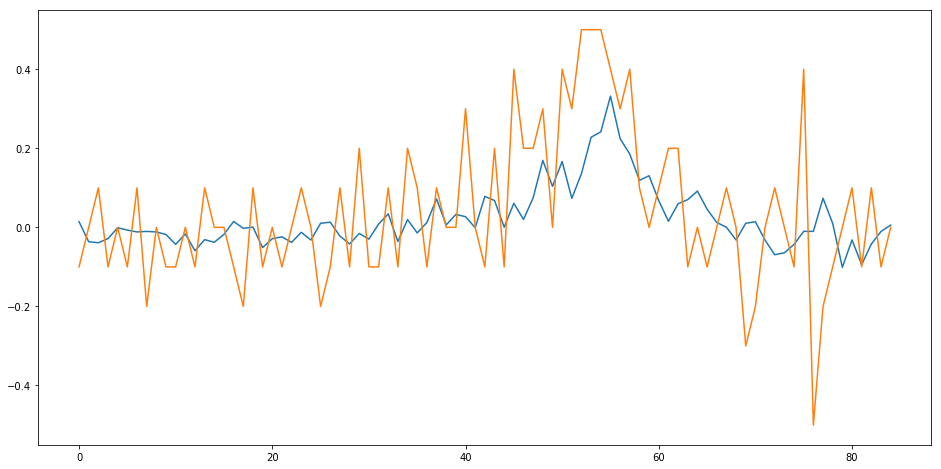

In [32]:
plt.close()
plt.figure(figsize=(16, 8))
plt.plot(ret["pred_all"][149]["val"])
plt.plot(data_feed["y_val"])
plt.show()